# Required libraries

In [1]:
import sys
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

## Database Connection and Data Loading

In [2]:
# Add project directory path
sys.path.append(os.path.abspath(".."))

# Establish database connection
from database.db_connection import DatabaseConnector

# Error handling for database connection
try:
    db_connector = DatabaseConnector()
    engine = db_connector.get_engine()
except Exception as e:
    print(f"Error connecting to the database: {e}")
    sys.exit(1)  # Exit program on connection error

# Load data
try:
    forecast_df = pd.read_sql("SELECT datetime, temperature_2m FROM historical_forecast;", engine)
    weather_df = pd.read_sql("SELECT datetime, temperature_2m, relative_humidity_2m, wind_speed_10m FROM historical_weather;", engine)
except Exception as e:
    print(f"Error loading data: {e}")
    sys.exit(1)

# Convert datetime format
try:
    forecast_df['datetime'] = pd.to_datetime(forecast_df['datetime'])
    weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
except Exception as e:
    print(f"Error in datetime formatting: {e}")
    sys.exit(1)

# Data preparation

In [3]:
# Merge forecast and weather data for comparison
merged_df = pd.merge(forecast_df, weather_df, how='inner', on=['datetime'], suffixes=('_forecast', '_actual'))

# Calculate temperature differences
merged_df['temperature_difference'] = merged_df['temperature_2m_forecast'] - merged_df['temperature_2m_actual']

# Define features (X) and target (y) and split data into training and testing sets

In [4]:
X = merged_df[['temperature_2m_forecast']]
y = merged_df['temperature_difference']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models

In [5]:
linear_model = LinearRegression()
rf_model = RandomForestRegressor(random_state=42)

# Train models

In [6]:
linear_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

# Make predictions

In [7]:
y_pred_linear = linear_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluate models

In [8]:
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print evaluation metrics

In [9]:
print("=== Linear Regression ===")
print(f"Mean Squared Error (MSE): {mse_linear:.2f}")
print(f"R²: {r2_linear:.2f}")

print("\n=== Random Forest Regressor ===")
print(f"Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"R²: {r2_rf:.2f}")

=== Linear Regression ===
Mean Squared Error (MSE): 2.10
R²: 0.03

=== Random Forest Regressor ===
Mean Squared Error (MSE): 2.13
R²: 0.02


# Feature importance from Random Forest

In [10]:
feature_importances = rf_model.feature_importances_
print("\nFeature Importances (Random Forest):")
for feature, importance in zip(X.columns, feature_importances):
    print(f"{feature}: {importance:.2f}")


Feature Importances (Random Forest):
temperature_2m_forecast: 1.00


# Visualization of predictions

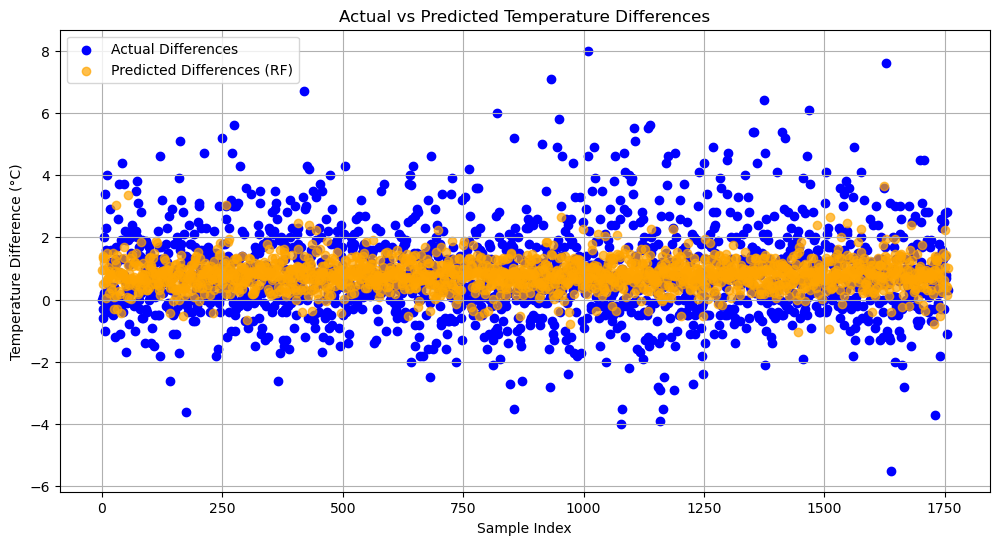

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Differences')
plt.scatter(range(len(y_pred_rf)), y_pred_rf, color='orange', label='Predicted Differences (RF)', alpha=0.7)
plt.title("Actual vs Predicted Temperature Differences")
plt.xlabel("Sample Index")
plt.ylabel("Temperature Difference (°C)")
plt.legend()
plt.grid()
plt.show()


## Interpretation:

Both models are ineffective:

The very low R² values and relatively high MSE values indicate that neither the linear regression nor the random forest model can reliably predict the temperature differences.

Possible reasons for the poor performance:

Limited input data: The only feature used is temperature_2m_forecast, which may not be sufficient to explain the variance in the temperature differences.